In [1]:
from firelab.config import Config

import torchvision
import torch
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import torchvision.utils as vutils

import os
import pandas as pd

import math

from modules import Autoencoder
from evaluation import fit_FC
from utils import load_dataset

# Section 1. Visualize interpolations

In [2]:
def build_ae_from_cfg(file, bn=False, device='cuda:0'):
    scales = int(round(np.log2(file['width'] // file['latent_width'])))
    
    ae = Autoencoder(scales=scales,depth=file['depth'], latent=file['latent'],
                     colors=file['colors'], batch_norm=bn).to(device)
    
    ae.load_state_dict(torch.load(file['log_dir'] + 'Autoencoder.torch'));
    ae.eval()
    
    return ae

In [3]:
def visualize(models, test_index, dataset, device):
    """
    Input:
    models - list of models to compare
    test_index - list of integers, pair of objects in the test set
    dataset - str, MNIST/ SVHN/ CIFAR10
    
    
    Output - str, path to location where a grid was saved
    """
    
    if dataset == 'MNIST':
        n_channels=1
        test_set = torchvision.datasets.MNIST(
                root = '/root/AutoEncoders/MNIST',
                train = False,
                download = False,
                transform = torchvision.transforms.Compose([torchvision.transforms.Pad(2), torchvision.transforms.ToTensor()]))
    elif dataset == 'SVHN':
        n_channels=3
        test_set = torchvision.datasets.SVHN(
                root = '/root/AutoEncoders/SVHN',
                split = 'test',
                download = False,
                transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
        
    elif dataset == 'CIFAR10':
        n_channels=3
        test_set = torchvision.datasets.CIFAR10(
            root = '/root/AutoEncoders/CIFAR10',
            train = False,
            download = False,
            transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()]))
        
        
    index_of_left, index_of_right = test_index
    
    left_image = test_set[index_of_left][0].reshape(1,n_channels,32,32).to(device)
    right_image = test_set[index_of_right][0].reshape(1,n_channels,32,32).to(device)
    
    reconstructions = []
    
    for ae in models:
        ae = ae.to(device)
        code_left, code_right = ae.encoder(left_image), ae.encoder(right_image)
        
        codes = torch.cat([(1 - alpha) * code_left + alpha * code_right  for alpha in np.linspace(0, 1, 11)], dim=0)
        reconstructions.append(ae.decoder(codes))            
    
    vutils.save_image(torch.cat(reconstructions), f'{dataset}_Interpolations.png', nrow=11, normalize=True)
    
    return f'{dataset}_Interpolations.png'

# MNIST visualization of interpolations

### Load models from config

In [4]:
device = 'cuda:2'

mnist_models_path = ['configs_ae/MNIST_Z2_ae.yaml', 'configs_ae/MNIST_Z2_ae_BN.yaml', 'configs_ae/MNIST_Z16_ae.yaml',
                     'configs/MNIST_Z2.yaml', 'configs/MNIST_Z2_BN.yaml', 'configs/MNIST_Z16.yaml']

models = []
for model_path in mnist_models_path:
    cfg = Config.load(model_path).to_dict()

    models.append(build_ae_from_cfg(cfg, device=device, bn=True if 'BN' in model_path else False))

### Plot

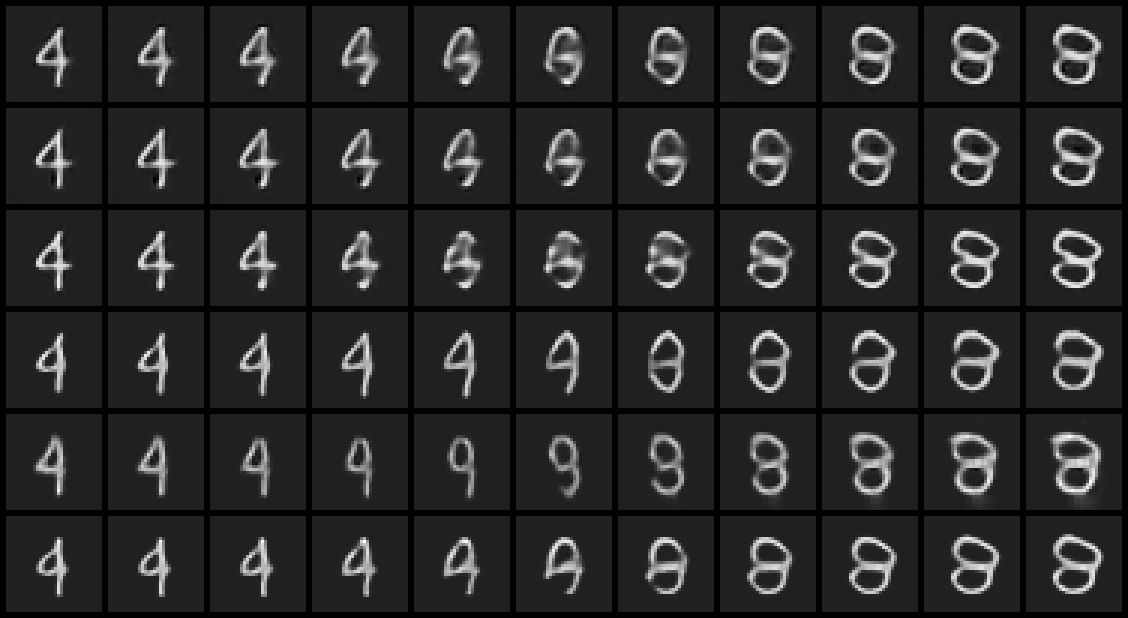

In [7]:
# name_viz = visualize(models, test_index=[191, 338], device=device, dataset='MNIST')

# 53 - > 155
# 11 -> 151
# 159 -> 268

name_viz = visualize(models, test_index=[159, 268], device=device, dataset='MNIST')
viz = Image.open(name_viz)
size = np.array(viz.size)

viz.resize(size * 3)

# SVHN visualization of interpolations

In [18]:
device = 'cuda:2'

svhn_models_path = ['configs_ae/SVHN_Z2_ae.yaml', 'configs_ae/SVHN_Z2_ae_BN.yaml', 'configs_ae/SVHN_Z16_ae.yaml',
                    'configs/SVHN_Z2.yaml', 'configs/SVHN_Z2_BN.yaml', 'configs/SVHN_Z16.yaml']

models = []
for model_path in svhn_models_path:
    cfg = Config.load(model_path).to_dict()

    models.append(build_ae_from_cfg(cfg, device=device, bn=True if 'BN' in model_path else False))

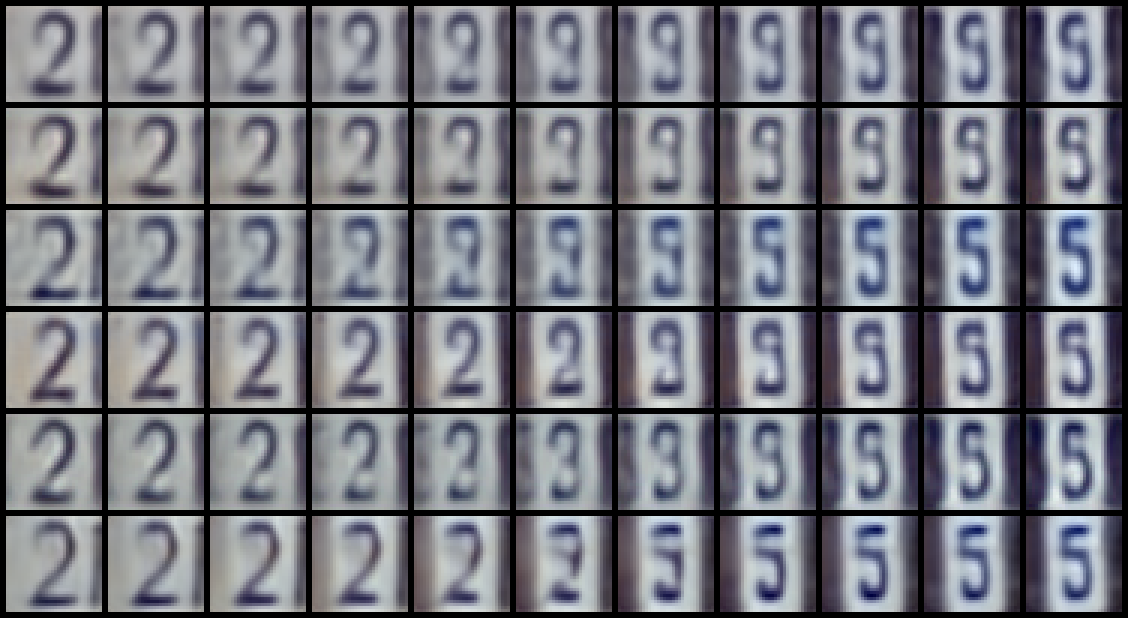

In [19]:
# name_viz = visualize_rgb(models, test_index=[8, 9], device=device, dataset='SVHN')

name_viz = visualize(models, test_index=[145, 283], device=device, dataset='SVHN')

viz = Image.open(name_viz)
size = np.array(viz.size)

viz.resize(size * 3)

# CIFAR10 visualization of interpolations

In [72]:
device = 'cuda:2'

cifar10_models_path = ['configs_ae/CIFAR10_Z16_ae.yaml', 'configs_ae/CIFAR10_Z16_ae_BN.yaml', 'configs_ae/CIFAR10_Z64_ae.yaml',
                      'configs/CIFAR10_Z16.yaml', 'configs/CIFAR10_Z16_BN.yaml', 'configs/CIFAR10_Z64.yaml']

models = []
for model_path in cifar10_models_path:
    cfg = Config.load(model_path).to_dict()

    models.append(build_ae_from_cfg(cfg, device=device, bn=True if 'BN' in model_path else False))

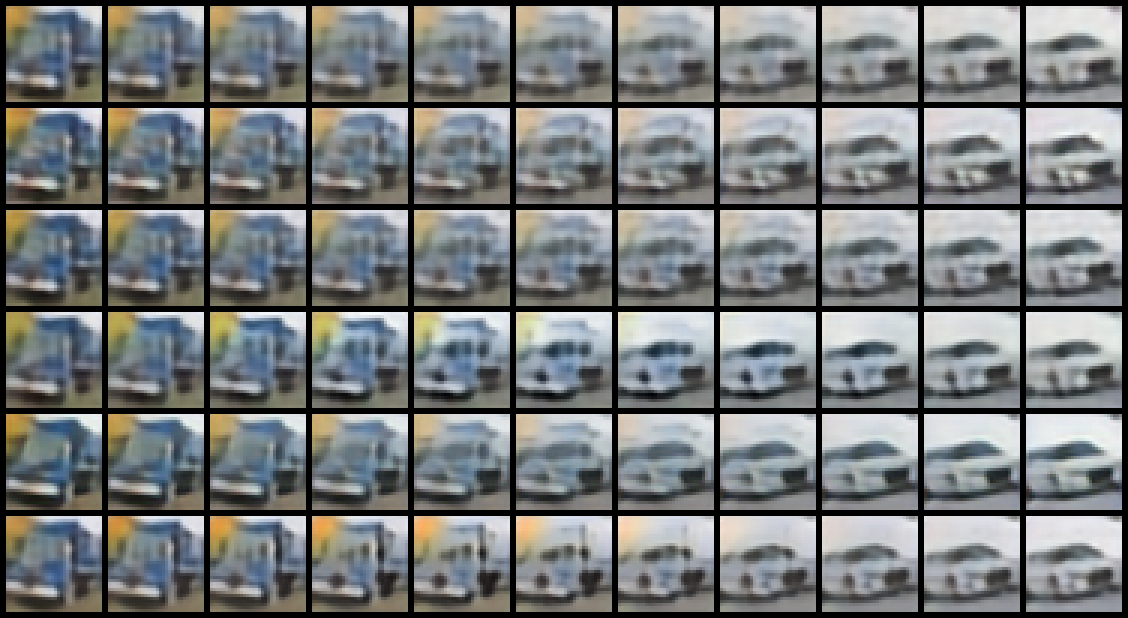

In [99]:
# name_viz = visualize(models, test_index=[99, 109], device=device, dataset='CIFAR10')

# name_viz = visualize(models, test_index=[14, 521], device=device, dataset='CIFAR10')

name_viz = visualize(models, test_index=[14, 546], device=device, dataset='CIFAR10')
viz = Image.open(name_viz)
size = np.array(viz.size)

viz.resize(size * 3)

# Section 2. Evaluation of AEs

### Replication of Table1 from the project

In [40]:
# os.mkdir('FC_results')

In [81]:
config_files = mnist_models_path + svhn_models_path + cifar10_models_path
print('Config files:', config_files)


test_scores = [[] for _ in range(len(config_files))]
n_runs = 5
device = 'cuda:2'

for index, conf in enumerate(config_files):
    print(f'Current config: {conf}')
    
    args = Config.load(conf).to_dict()
    
    if 'BN' in conf:
        autoencoder = build_ae_from_cfg(args, bn=True, device=device)
    else:
        autoencoder = build_ae_from_cfg(args, bn=False, device=device)
    
    train_loader, test_loader = load_dataset(args['dataset'], args['batch_size'])
    
    for _ in range(n_runs):
        test_scores[index].append(fit_FC(autoencoder, (train_loader, test_loader), args))
        
table = []

for index, file in enumerate(config_files):
    name = 'FC_results/' + file.replace('.yaml', '.csv').split('/')[-1]
    
    df = pd.DataFrame(test_scores[index])
    df.to_csv(name, index=False)
    
    table.append([np.round(df.iloc[:, -1].mean(), 4), np.round(df.iloc[:, -1].std(), 4)])

Config files: ['configs_ae/MNIST_Z2_ae.yaml', 'configs_ae/MNIST_Z2_ae_BN.yaml', 'configs_ae/MNIST_Z16_ae.yaml', 'configs/MNIST_Z2.yaml', 'configs/MNIST_Z2_BN.yaml', 'configs/MNIST_Z16.yaml', 'configs_ae/SVHN_Z2_ae.yaml', 'configs_ae/SVHN_Z2_ae_BN.yaml', 'configs_ae/SVHN_Z16_ae.yaml', 'configs/SVHN_Z2.yaml', 'configs/SVHN_Z2_BN.yaml', 'configs/SVHN_Z16.yaml', 'configs_ae/CIFAR10_Z16_ae.yaml', 'configs_ae/CIFAR10_Z16_ae_BN.yaml', 'configs_ae/CIFAR10_Z64_ae.yaml', 'configs/CIFAR10_Z16.yaml', 'configs/CIFAR10_Z16_BN.yaml', 'configs/CIFAR10_Z64.yaml']
